In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
%matplotlib inline
import zipfile

In [17]:
with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('Dataset')

In [26]:
dataset=pd.read_csv('Dataset/emergency_classification.csv')

In [27]:
dataset.shape

(2351, 2)

In [31]:
img_name_list=[]
emergency_or_not_list=[]
updated_dataset=pd.DataFrame(columns=['image_name','emergency_or_not'])
for img_name in dataset.image_names:
  try:
    img1=plt.imread('Dataset/Dataset/images/'+img_name)
    img1=img1/255.0
    img_name_list.append(img_name)
    emergency_or_not_list.append(((dataset[dataset.image_names==img_name]['emergency_or_not'].values[0])).T)
  except Exception:
    pass

img_name_list=np.array(img_name_list)
emergency_or_not_list=np.array(emergency_or_not_list)


updated_dataset=pd.DataFrame(np.column_stack((img_name_list, emergency_or_not_list)), columns=['image_name','emergency_or_not'])
updated_dataset.emergency_or_not=updated_dataset.emergency_or_not.astype(int)


In [33]:
updated_dataset.to_csv('Dataset/updated_emergency_classification.csv', index=False)
updated_dataset.shape

(2268, 2)

In [34]:
X=[]
y=[]

for img_name in updated_dataset.image_name:
  try:
    
    img1=plt.imread('Dataset/Dataset/images/'+img_name)
    img1=img1/255.0
   
    X.append(img1)
    y.append(updated_dataset[updated_dataset.image_name==img_name]['emergency_or_not'])
  except Exception:
    pass
X=np.array(X)
y=np.array(y)



(2351, 2)

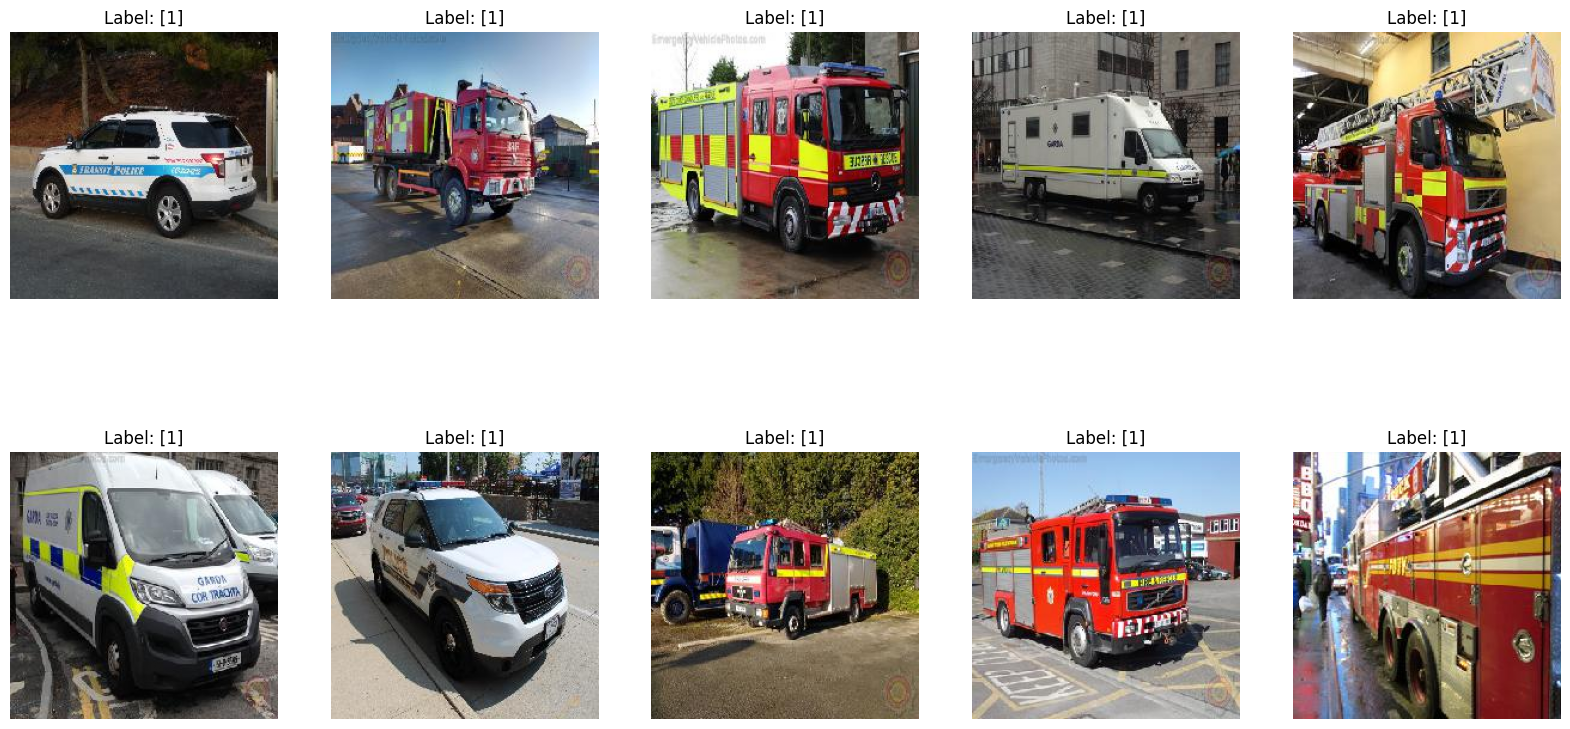

In [22]:
fig, axes=plt.subplots(2, 5, figsize=(20, 10))
for i in range(10):
    axes[i//5, i%5].imshow(X[i])
    axes[i//5, i%5].set_title(f'Label: {y[i]}')
    axes[i//5, i%5].axis('off')

In [15]:
X=X.reshape(-1, 224, 224, 3).astype('float32')
X.shape

(2268, 224, 224, 3)

In [24]:
y.shape

(2268, 1)

In [25]:
224*224*3

150528

In [26]:
X=X.reshape(-1, 224*224*3).astype('float32')
X.shape

(2268, 150528)

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [28]:
import torch

In [29]:
X_train=torch.FloatTensor(X_train)

X_valid=torch.FloatTensor(X_valid)
y_train=torch.FloatTensor(y_train)
y_valid=torch.FloatTensor(y_valid)


 Explanation of Super class through a random unrelated example

Defining the model architecture


In [38]:
import torch.nn as nn
from torch.nn import Linear, Sigmoid, Sequential


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_layers = Sequential(
            Linear(X_train.shape[1], 100),
            nn.Sigmoid(),
            nn.BatchNorm1d(100),
            nn.Dropout(0.85, inplace=True),
            Linear(100, 100),
            nn.Sigmoid(),
            nn.BatchNorm1d(100),       
            nn.Dropout(0.85, inplace=True),
            Linear(100, 1),
            nn.Sigmoid()
        )
    def forward(self, x) :
        x = self.linear_layers(x)
        return x  

In [39]:
from torch.nn import BCELoss
from torch.optim import Adam


torch.manual_seed(42)
model = Net()   
optimizer=Adam(model.parameters(), lr=0.001)
criterion=BCELoss() # Binary Cross Entropy Loss
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Net(
  (linear_layers): Sequential(
    (0): Linear(in_features=150528, out_features=100, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.85, inplace=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.85, inplace=True)
    (8): Linear(in_features=100, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [44]:
batch_size=128
train_prediction=[]
train_target=[]
for epoch in tqdm(range(1000)):
    train_loss=0.0
    permutation = torch.randperm(X_train.size()[0])
    training_loss=[]

    for i in range(0, X_train.size()[0], batch_size):
        model.train()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        with torch.no_grad():
            output=model(batch_x).data.cpu()
        train_predicted_label=[]
        for i in output:
            if i>0.5:
                train_predicted_label.append(1)
            else:
                train_predicted_label.append(0)
        train_prediction.append(train_predicted_label)
        train_target.append(batch_y)
      


100%|██████████| 1000/1000 [11:02<00:00,  1.51it/s]


In [45]:
training_accuracy=[]
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(), train_prediction[i]))
print(f"Training Accuracy: {np.mean(training_accuracy)}")

Training Accuracy: 0.4920899910444947


In [46]:
# predict on validation set
valid_prediction=[]
valid_target=[]
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0, X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]
    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
    with torch.no_grad():
        output=model(batch_x).data.cpu()
    valid_predicted_label=[]
    for i in output:
        if i>0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

100%|██████████| 6/6 [00:00<00:00, 20.55it/s]


In [47]:
valid_accuracy=[]
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(), valid_prediction[i]))
print(f"Validation Accuracy: {np.mean(valid_accuracy)}")

Validation Accuracy: 0.5015561483739838
